<a href="https://colab.research.google.com/github/RayNCode/code_collab/blob/main/XGB_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data_url = "https://raw.githubusercontent.com/RayNCode/code_collab/main/project-3-files"
learn_dataset = pd.read_csv(f"{data_url}/learn_dataset.csv").copy()
learn_dataset_Emp_contract = pd.read_csv(f"{data_url}/learn_dataset_Emp_contract.csv").copy()
learn_dataset_sport = pd.read_csv(f"{data_url}/learn_dataset_sport.csv").copy()
learn_dataset_job = pd.read_csv(f"{data_url}/learn_dataset_job.csv").copy()

code_work_description_map = pd.read_csv(f"{data_url}/code_work_description_map.csv").copy()
city_adm = pd.read_csv(f"{data_url}/city_adm.csv").copy()
code_Club = pd.read_csv(f"{data_url}/code_Club.csv").copy()
departments = pd.read_csv(f"{data_url}/departments.csv").copy()

test_dataset_job = pd.read_csv(f"{data_url}/test_dataset_job.csv").copy()
test_dataset = pd.read_csv(f"{data_url}/test_dataset.csv").copy()
test_dataset_Emp_contract = pd.read_csv(f"{data_url}/test_dataset_Emp_contract.csv").copy()
test_dataset_sport = pd.read_csv(f"{data_url}/test_dataset_sport.csv").copy()

In [ ]:
def preprocess_data_base(learn_dataset_job, work_desc, learn_dataset, dept_code, emp_contract, learn_dataset_sport, code_club, departments):
    # Chargement et fusion des datasets de travail
    merged_df = pd.merge(learn_dataset_job, work_desc, left_on='work_description', right_on='N3', how='left')

    # Conversion des colonnes N2, N1 et N3 en chaînes de caractères
    merged_df['N2'] = merged_df['N2'].astype(str)
    merged_df['N1'] = merged_df['N1'].astype(str)
    merged_df['N3'] = merged_df['N3'].astype(str)

    # Remplir les valeurs manquantes
    merged_df['N2'].fillna(merged_df['N3'].str[:-2], inplace=True)
    merged_df['N1'].fillna(merged_df['N2'].str[:-1], inplace=True)

    # Fusion avec d'autres datasets
    data_2 = pd.merge(learn_dataset, merged_df, on="Id", how="left")
    df_1 = data_2.merge(dept_code, on='insee_code')
    df_2 = df_1.merge(emp_contract, on='Id', how='left')
    df_3 = df_2.merge(learn_dataset_sport, on='Id', how='left')
    df_4 = df_3.merge(code_Club, left_on='Club', right_on='Code', how='left')
    final_df = df_4.merge(departments, on='dep', how='left')

    # Conversion de type pour les colonnes 'Categorie' et 'REG'
    final_df['Categorie'] = final_df['Categorie'].astype(str).astype('object')
    final_df['REG'] = final_df['REG'].astype(str).astype('object')


    # Création et application d'une condition pour filtrer et imputer des valeurs
    condition = (final_df['ACTIVITY_TYPE'] != "TYPE1|1")
    final_df.loc[condition, ['EMOLUMENT', 'Working_hours']] = 0.0
    # Traitement des valeurs manquantes dans les colonnes catégorielles
    categorical_columns = final_df.select_dtypes(include=['object']).columns
    final_df[categorical_columns] = final_df[categorical_columns].fillna("None")


    return final_df

In [ ]:
learn_dataset_base = preprocess_data_base(learn_dataset_job, code_work_description_map, learn_dataset, city_adm, learn_dataset_Emp_contract, learn_dataset_sport, code_Club, departments)
test_dataset_base = preprocess_data_base(test_dataset_job, code_work_description_map, test_dataset, city_adm, test_dataset_Emp_contract, test_dataset_sport, code_Club,departments)

In [ ]:
def preprocess_learn_test(final_df): #ajouter l'ID quelque part
    # Séparer la variable cible si elle est présente
    if 'target' in final_df.columns:
        y = final_df['target'].copy()
        y = np.where(y == 'B', 1, 0)
        X = final_df.drop(['target'], axis='columns')
        X = X.drop(["Id", 'Nom de la commune', 'Nom fédération', 'Nom catégorie', 'Nom du département', 'Code'], axis="columns")
        imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=100, random_state=0)
        columns_to_impute = ['Working_hours', 'EMOLUMENT']
        X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])
    else:
        X = final_df.copy()
        X_test_id = X['Id'].copy()
        # Suppression des colonnes non nécessaires
        X = X.drop(["Id", 'Nom de la commune', 'Nom fédération', 'Nom catégorie', 'Nom du département', 'Code'], axis="columns")



    if 'target' in final_df.columns:
      return X, y
    else:
      return X, X_test_id

In [ ]:
X, y = preprocess_learn_test(learn_dataset_base)
X_testing, X_testing_id = preprocess_learn_test(test_dataset_base)
print("Shape de X_train:", X.shape)
print("Shape de y_test:", y.shape)

Shape de X_train: (49993, 27)
Shape de y_test: (49993,)
Shape de X_test: (49992, 27)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')

In [ ]:
def tune_hyperparameters(pipeline, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the RandomizedSearch object
    clf_grid = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=cv, scoring='accuracy',
        n_iter=50,
        n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_


In [ ]:
# Define the hyperparameter grid to search
xgb_param_grid = {
    'xgbclassifier__subsample': np.arange(0.7, 0.9, 0.01),
    'xgbclassifier__scale_pos_weight': np.arange(0.7, 0.9, 0.01),
    'xgbclassifier__reg_lambda': np.arange(0.08, 0.10, 0.01),
    'xgbclassifier__reg_alpha': np.arange(0.01, 1, 0.01),
    'xgbclassifier__n_estimators': np.arange(140, 161, 1),
    'xgbclassifier__min_child_weight': np.arange(3, 3.5, 0.01),
    'xgbclassifier__max_depth': np.arange(4, 6, 1),
    'xgbclassifier__max_delta_step': np.arange(1.5, 2, 0.01),
    'xgbclassifier__learning_rate': np.arange(0.7, 1, 0.01),
    'xgbclassifier__gamma': np.arange(0.8, 1, 0.001),
    'xgbclassifier__colsample_bytree': np.arange(0.65, 0.75, 0.01),
    'xgbclassifier__colsample_bylevel': np.arange(0.8, 1, 0.01),
    }

In [ ]:
XGBoost = XGBClassifier(random_state=42)
XGB = make_pipeline(preprocessing, XGBoost)

In [ ]:
xgb_opt = tune_hyperparameters(XGB, xgb_param_grid, X_train, y_train)

Best hyperparameters:
 {'xgbclassifier__subsample': 0.9000000000000001, 'xgbclassifier__scale_pos_weight': 0.8300000000000001, 'xgbclassifier__reg_lambda': 0.08, 'xgbclassifier__reg_alpha': 0.8, 'xgbclassifier__n_estimators': 151, 'xgbclassifier__min_child_weight': 3.279999999999994, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_delta_step': 1.54, 'xgbclassifier__learning_rate': 0.76, 'xgbclassifier__gamma': 0.9980000000000002, 'xgbclassifier__colsample_bytree': 0.7100000000000001, 'xgbclassifier__colsample_bylevel': 0.9400000000000002}


Best paramsV1: {'xgbclassifier__subsample': 0.75, 'xgbclassifier__scale_pos_weight': 0.7300000000000001, 'xgbclassifier__reg_lambda': 0.09999999999999999, 'xgbclassifier__reg_alpha': 0.76, 'xgbclassifier__n_estimators': 155, 'xgbclassifier__min_child_weight': 3.300000000000001, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_delta_step': 1.84, 'xgbclassifier__learning_rate': 0.75, 'xgbclassifier__gamma': 0.88, 'xgbclassifier__colsample_bytree': 0.7200000000000001, 'xgbclassifier__colsample_bylevel': 0.9500000000000002}

Best paramsV2: {'xgbclassifier__subsample': 0.9000000000000001, 'xgbclassifier__scale_pos_weight': 0.8300000000000001, 'xgbclassifier__reg_lambda': 0.08, 'xgbclassifier__reg_alpha': 0.8, 'xgbclassifier__n_estimators': 151, 'xgbclassifier__min_child_weight': 3.279999999999994, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_delta_step': 1.54, 'xgbclassifier__learning_rate': 0.76, 'xgbclassifier__gamma': 0.9980000000000002, 'xgbclassifier__colsample_bytree': 0.7100000000000001, 'xgbclassifier__colsample_bylevel': 0.9400000000000002}


In [ ]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1], average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score','Macro AUC'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [ ]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    # Set font scale
    sns.set(font_scale=1.5)

    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    # Plot confusion matrix for test set
    cmap = plt.cm.Purples  # Remplace 'purple_cmap' par 'cmap'

    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=cmap, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 3.6)
    table.set_fontsize(12)
    ax2.axis('tight')
    # Hide the axes
    ax2.axis('off')
    # set the title
    ax2.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
          cell.set_color('purple')

    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     15412
           1       0.96      0.95      0.96     24582

    accuracy                           0.95     39994
   macro avg       0.95      0.95      0.95     39994
weighted avg       0.95      0.95      0.95     39994


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3853
           1       0.93      0.92      0.93      6146

    accuracy                           0.91      9999
   macro avg       0.91      0.91      0.91      9999
weighted avg       0.91      0.91      0.91      9999





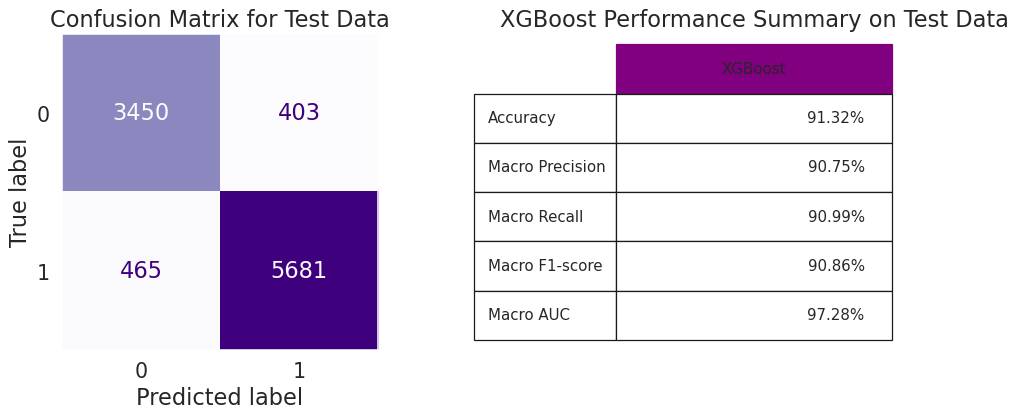

In [ ]:
model_evaluation(xgb_opt, X_train, X_test, y_train, y_test, 'XGBoost')